# Завдання 2. Граничні задачі для диференціальних рівнянь другого порядку у частинних похідних в декартовій системі координат

2.7) 
$$
\frac{\partial}{\partial x}\left(k_x \frac{\partial u}{\partial x}\right)+\frac{\partial}{\partial y}\left(k_y\frac{\partial u}{\partial y}\right)-qu=f,\qquad 
\begin{cases}
k_x=1+\ln(1+x+y),\\ k_y=1+\sqrt{x^2+y^2},\\ q=-(x+y),\\ f=\cos(x+y).
\end{cases}, \quad [A,B]\times[C,D]=[1.1,2.3]\times[1,2]
$$

Границі:
$$
\begin{cases}
u(1.1,y)=0 & (Діріхле)\\
2u-3\frac{\partial u}{\partial x}(2.3,y)=1 & (Робін)\\
u(x,1)=x & (Діріхле)\\
\frac{\partial u}{\partial y}(x,2)=1 & (Нейман)
\end{cases}
$$


Після дискретизації:
$$\frac{k_{x}{}_{i-0.5,j}}{\Delta x^{2}} u_{i-1,j} +\frac{k_{x}{}_{i+0.5,j}}{\Delta x^{2}} u_{i+1,j} +\frac{k_{y}{}_{i,j-0.5}}{\Delta y^{2}} u_{i,j-1} +\frac{k_{y}{}_{i,j+0.5}}{\Delta y^{2}} u_{i,j+1} -\left(\frac{k_{x}{}_{i+0.5,j} +k_{x}{}_{i-0.5,j}}{\Delta x^{2}} +\frac{k_{y}{}_{i,j+0.5} +k_{y}{}_{i,j-0.5}}{\Delta y^{2}} +q_{i,j}\right) u_{i,j} =f_{i,j}$$

Граничні умови:

$
u(1.1,y)=0 \Rightarrow \boxed{U_{1, j} = 0}
$

$
u(x,1)=x \Rightarrow \boxed{U_{i, 1} = x_i}
$

$
2u-3\frac{\partial u}{\partial x}(2.3, y)=1 \Rightarrow 2U_{n_x, j}-3\frac{U_{n_x, j}-U_{n_x-1, j}}{\Delta x}=1\Rightarrow \boxed{U_{n_x, j}=-\frac{3}{2\Delta x-3} U_{n_{x} -1,j}+\frac{1}{2-\frac{3}{\Delta x}}}
$

$
\frac{\partial u}{\partial y}(x, 2)=1 \Rightarrow \frac{U_{i, n_y}-U_{i, n_y-1}}{\Delta y}=1 \Rightarrow \boxed{U_{i, n_y} = U_{i, n_y-1} + \Delta y}
$

In [ ]:
from solver import relax2d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- PDE coefficient functions ---
def kx_fun(x, y):
    return 1 + np.log(1 + x + y)

def ky_fun(x, y):
    return 1 + np.sqrt(x**2 + y**2)

def q_fun(x, y):
    return -(x + y)

def f_fun(x, y):
    return np.cos(x + y)


class GridConfig:
    """Stores geometry, grid spacing, and generated mesh."""
    def __init__(self, nx=100, ny=100, Ax=1.1, Bx=2.3, Cy=1.0, Dy=2.0):
        self.nx, self.ny = nx, ny
        self.Ax, self.Bx = Ax, Bx
        self.Cy, self.Dy = Cy, Dy

        self.x = np.linspace(Ax, Bx, nx)
        self.y = np.linspace(Cy, Dy, ny)
        self.dx = (Bx - Ax) / (nx - 1)
        self.dy = (Dy - Cy) / (ny - 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

In [3]:
def compute_half_nodes(arr):
    """
    Compute a_{i+1/2} = 0.5 * (a_i + a_{i+1}).
    """
    n = len(arr)
    half = np.empty(n)
    half[1:] = 0.5 * (arr[:-1] + arr[1:])
    half[0]   = 0.5 * (arr[0]   + arr[1])
    half[-1]  = 0.5 * (arr[-2]  + arr[-1])
    return half


def compute_diffusion_coeffs(cfg: GridConfig):
    """
    Compute kx_{i±1/2,j} and ky_{i,j±1/2} on half-staggered grids.
    """
    x_w = compute_half_nodes(cfg.x)
    x_e = compute_half_nodes(cfg.x)
    y_s = compute_half_nodes(cfg.y)
    y_n = compute_half_nodes(cfg.y)

    Xw = x_w[:, None]
    Xe = x_e[:, None]
    Ys = y_s[None, :]
    Yn = y_n[None, :]

    kxw = kx_fun(Xw, cfg.Y)
    kxe = kx_fun(Xe, cfg.Y)
    kys = ky_fun(cfg.X, Ys)
    kyn = ky_fun(cfg.X, Yn)

    return kxw, kxe, kys, kyn

In [4]:
def assemble_system(cfg: GridConfig):
    """
    Build finite-difference coefficients and apply all boundary conditions
    directly to the operator (ax, ay, cx, cy, b, rhs).
    """
    nx, ny = cfg.nx, cfg.ny
    dx, dy = cfg.dx, cfg.dy
    X, Y   = cfg.X, cfg.Y
    x      = cfg.x

    inv_dx2 = 1.0 / (dx * dx)
    inv_dy2 = 1.0 / (dy * dy)

    # Diffusion coefficients at half nodes
    kxw, kxe, kys, kyn = compute_diffusion_coeffs(cfg)

    # Allocate operator matrices
    ax = np.zeros((nx, ny))
    cx = np.zeros((nx, ny))
    ay = np.zeros((nx, ny))
    cy = np.zeros((nx, ny))
    b  = np.zeros((nx, ny))
    rhs = np.zeros((nx, ny))

    # Interior coefficients
    cx[:] = kxe * inv_dx2
    ax[:] = kxw * inv_dx2
    cy[:] = kyn * inv_dy2
    ay[:] = kys * inv_dy2
    b[:]  = ax + cx + ay + cy + q_fun(X, Y)

    # RHS
    rhs[:] = f_fun(X, Y)

    # --- Boundary conditions encoded in the operator ---

    # Right boundary: Robin
    row = nx - 2
    A = 3.0 / (2.0*dx - 3.0)
    C = 1.0 / (2.0 - 3.0/dx)
    b[row, :]   += A * (kxe[row, :] * inv_dx2)
    rhs[row, :] -= C * (kxe[row, :] * inv_dx2)
    cx[row, :]   = 0.0

    # Top boundary: Neumann u_y = 1
    col = ny - 2
    cy_old = cy[:, col].copy()
    cy[:, col] = 0.0
    b[:, col] -= cy_old
    rhs[:, col] -= cy_old * dy

    # Bottom boundary: Dirichlet u = -x
    b[:, 0] = 1.0
    ax[:, 0] = cx[:, 0] = ay[:, 0] = cy[:, 0] = 0.0
    rhs[:, 0] = -x

    # Left boundary: Dirichlet u = 0
    b[0, :] = 1.0
    ax[0, :] = cx[0, :] = ay[0, :] = cy[0, :] = 0.0
    rhs[0, :] = 0.0

    return ax, ay, cx, cy, b, rhs

def apply_boundary_values(U, cfg: GridConfig):
    """
    Apply boundary values directly to U.
    """
    nx, ny = cfg.nx, cfg.ny
    dx, dy = cfg.dx, cfg.dy
    x = cfg.x
    A = -3.0 / (2.0 * dx - 3.0)
    C =  1.0 / (2.0 - 3.0 / dx)

    U[0, :] = 0.0                   # Left: Dirichlet u=0
    U[:, 0] = x                     # Bottom: Dirichlet u=x
    U[-1, :] = A * U[-2, :] + C     # Right: Robin
    U[:, -1] = U[:, -2] + dy        # Top: Neumann 

    return U

In [5]:
cfg = GridConfig(nx=100, ny=100, Ax=1.1, Bx=2.3, Cy=1.0, Dy=2.0)

ax, ay, cx, cy, b, d_rhs = assemble_system(cfg)

U0 = np.zeros((cfg.nx, cfg.ny))
U0 = apply_boundary_values(U0, cfg)

U_final = relax2d(
    ax, ay, cx, cy, b, d_rhs,
    cfg.nx, cfg.ny,
    U0,
    omega=1.84,
    eps=1e-13,
    max_iter=50000
)

U_final = apply_boundary_values(U_final, cfg)

iter= 500 err= 0.004141982634469521
iter= 1000 err= 0.0020514685499577467
iter= 1500 err= 0.0010135209523944866
iter= 2000 err= 0.0005007080070402736
iter= 2500 err= 0.00024736376924838765
iter= 3000 err= 0.00012220462409207045
iter= 3500 err= 6.037250399426597e-05
iter= 4000 err= 2.9825706399755347e-05
iter= 4500 err= 1.4734733580823445e-05
iter= 5000 err= 7.279370720425504e-06
iter= 5500 err= 3.5962128386302084e-06
iter= 6000 err= 1.7766297730759106e-06
iter= 6500 err= 8.777048279284827e-07
iter= 7000 err= 4.336107446434312e-07
iter= 7500 err= 2.1421584239789127e-07
iter= 8000 err= 1.0582861875718663e-07
iter= 8500 err= 5.228230115505994e-08
iter= 9000 err= 2.582891678315491e-08
iter= 9500 err= 1.2760203560446826e-08
iter= 10000 err= 6.30390228906208e-09
iter= 10500 err= 3.1143052581228403e-09
iter= 11000 err= 1.5385523965960601e-09
iter= 11500 err= 7.600915452599111e-10
iter= 12000 err= 3.7550851317291745e-10
iter= 12500 err= 1.8551116198750606e-10
iter= 13000 err= 9.164491387991802

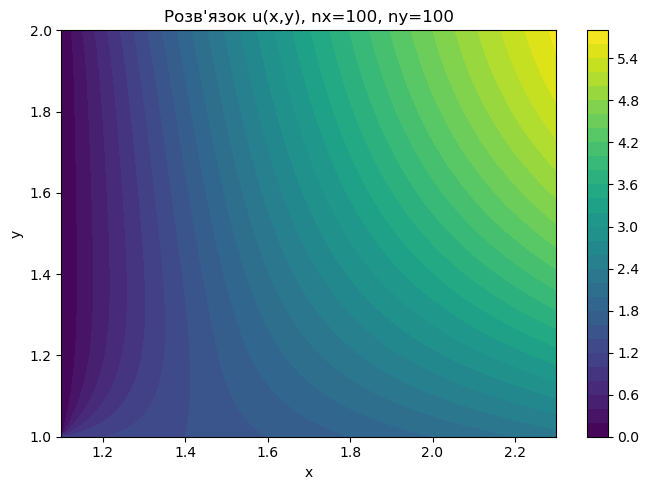

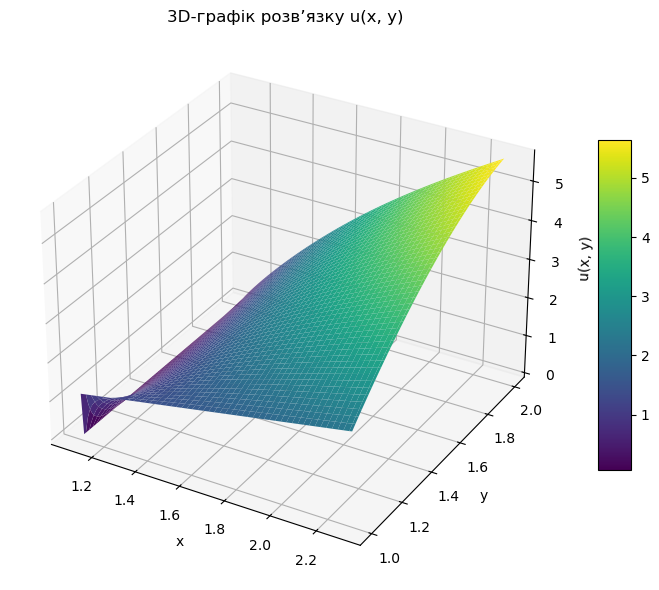

In [6]:
from mpl_toolkits.mplot3d import Axes3D 

X, Y = np.meshgrid(cfg.x, cfg.y, indexing='ij')

# 2D-контур
fig = plt.figure(figsize=(7, 5))
c = plt.contourf(X, Y, U_final, levels=30)
plt.colorbar(c)
plt.title(f"Розв'язок u(x,y), nx={cfg.nx}, ny={cfg.ny}")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

# 3D-поверхня
fig = plt.figure(figsize=(8, 6))
axis = fig.add_subplot(111, projection='3d')
surf = axis.plot_surface(X, Y, U_final, cmap='viridis', edgecolor='none')
axis.set_xlabel('x')
axis.set_ylabel('y')
axis.set_zlabel('u(x, y)')
axis.set_title("3D-графік розв’язку u(x, y)")
fig.colorbar(surf, ax=axis, shrink=0.6, aspect=10)
plt.tight_layout()
plt.show()

In [7]:
# --- Verification -------------------------
# PDE:  ax*U[i-1,j] + cx*U[i+1,j] + ay*U[i, j-1] + cy*U[i, j+1] - b*U[i,j] = d_rhs

pde_residual = np.zeros_like(U_final)
for i in range(1, cfg.nx-1):
    for j in range(1, cfg.ny-1):
        Rij = (ax[i, j] * U_final[i-1, j] +
               cx[i, j] * U_final[i+1, j] +
               ay[i, j] * U_final[i, j-1] +
               cy[i, j] * U_final[i, j+1] -
               b[i, j]  * U_final[i, j] -
               d_rhs[i, j])
        pde_residual[i, j] = Rij

# 2) Граничні умови
# Ліва: Діріхле u=0
bc_left_dirichlet = np.abs(U_final[0, 1:-1])

# Нижня: Діріхле u=x
bc_bottom_dirichlet = np.abs(U_final[1:-1, 0] - cfg.x[1:-1])

# Верхня: Нейман (du/dy = 1)
bc_top_neumann = np.abs((U_final[1:-1, cfg.ny-1] - U_final[1:-1, cfg.ny-2]) / cfg.dy - 1.0)

# Права: Робін у тій же дискретній формі, що в boundary_conditions_1
A = -3.0 / (2.0 * cfg.dx - 3.0)
C =  1.0 / (2.0 - 3.0 / cfg.dx)
bc_right_robin_discrete = np.abs(U_final[cfg.nx-1, 1:-1] - (A * U_final[cfg.nx-2, 1:-1] + C))

mask_int = (slice(1, cfg.nx-1), slice(1, cfg.ny-1))
pde_max   = np.max(np.abs(pde_residual[mask_int]))
pde_l2    = np.sqrt(np.mean(pde_residual[mask_int]**2))

print("--- Verification Results ---")
print(f"PDE residual (max, interior): {pde_max: .3e}")
print(f"PDE residual (L2 , interior): {pde_l2 : .3e}")
print(f"BC left  (Dirichlet u=0)     : {np.max(bc_left_dirichlet): .3e}")
print(f"BC bottom(Dirichlet u=x)     : {np.max(bc_bottom_dirichlet): .3e}")
print(f"BC top   (Neumann du/dy=1)   : {np.max(bc_top_neumann): .3e}")
print(f"BC right (Robin, discrete)   : {np.max(bc_right_robin_discrete): .3e}")

--- Verification Results ---
PDE residual (max, interior):  2.302e-09
PDE residual (L2 , interior):  2.497e-10
BC left  (Dirichlet u=0)     :  0.000e+00
BC bottom(Dirichlet u=x)     :  0.000e+00
BC top   (Neumann du/dy=1)   :  2.842e-14
BC right (Robin, discrete)   :  0.000e+00
